<a href="https://colab.research.google.com/github/skagnihotri/urban_sound_classification/blob/master/Urban_sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive 
#dataset downloaded
!wget -c https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O - | sudo tar -xz

--2019-08-19 15:44:59--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.65.20
Connecting to zenodo.org (zenodo.org)|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>]   5.61G  19.2MB/s    in 5m 6s   

2019-08-19 15:50:06 (18.8 MB/s) - written to stdout [6023741708/6023741708]



In [2]:
!apt-get install ffmpeg #backend for librosa

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [3]:
pip install librosa #sound preprocessing lib

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
from tqdm import tqdm
%matplotlib inline

In [0]:
data = pd.read_csv("/content/UrbanSound8K/metadata/UrbanSound8K.csv")

In [6]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
#count of datapoints in each of the folders
data["fold"].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
slice_file_name    8732 non-null object
fsID               8732 non-null int64
start              8732 non-null float64
end                8732 non-null float64
salience           8732 non-null int64
fold               8732 non-null int64
classID            8732 non-null int64
class              8732 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 545.8+ KB


In [8]:
#feature set
#This file is of a dog bark
y, sr = librosa.load(f"UrbanSound8K/audio/fold{data.fold[0]}/{data.slice_file_name[0]}")
mfccs = librosa.feature.mfcc(y, sr, n_mfcc= 40)
melspectrogram = librosa.feature.melspectrogram(y= y, sr= sr, n_mels= 40)
chroma_stft = librosa.feature.chroma_stft(y= y, sr= sr, n_chroma= 40)
chroma_cq = librosa.feature.chroma_cqt(y= y, sr= sr,n_chroma= 40)
chroma_cens = librosa.feature.chroma_cens(y= y, sr= sr,n_chroma= 40)
melspectrogram.shape, chroma_stft.shape, chroma_cq.shape, chroma_cens.shape, mfccs.shape

((40, 14), (40, 14), (40, 14), (40, 14), (40, 14))

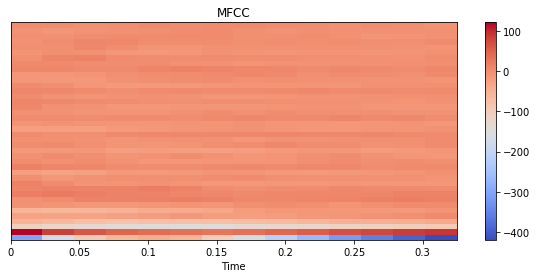

In [9]:
plt.figure(figsize= (10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

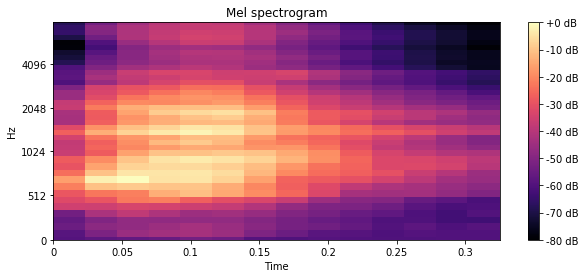

In [10]:
#Melspectrogram of a dog bark
plt.figure(figsize= (10, 4))
librosa.display.specshow(librosa.power_to_db(melspectrogram, ref= np.max), x_axis= "time", y_axis= 'mel', sr= sr, fmax= 8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()

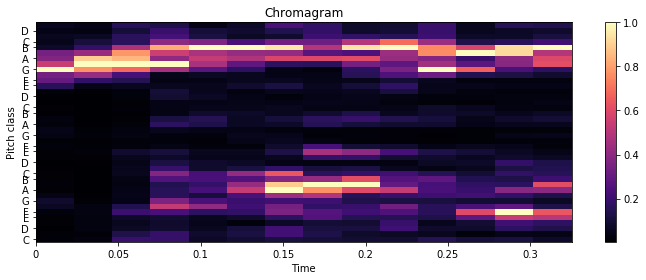

In [11]:
#Chromagram of dog bark
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

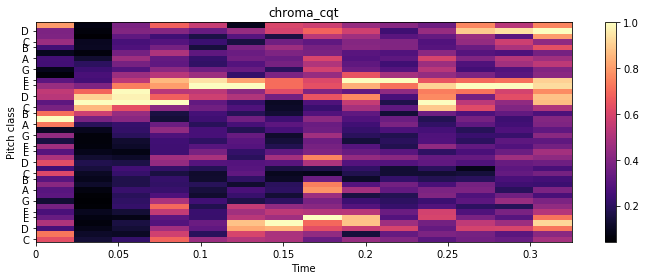

In [12]:
#Chroma cqt of a dog bark
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cqt')
plt.tight_layout()

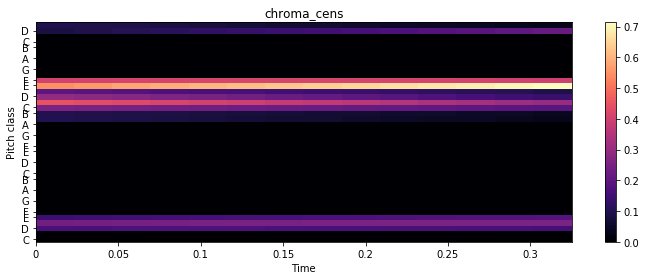

In [13]:
#Chroma cens of a dog bark
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cens')
plt.tight_layout()

## Using spectogram as features for CNN

In [22]:
#preprocessing
x_train = []
x_test = []
y_train = []
y_test = []
max_pad_len = 174
for i in tqdm(range(len(data))):
    y, sr = librosa.load(f"UrbanSound8K/audio/fold{data.fold[i]}/{data.slice_file_name[i]}")
    
    melspectrogram = librosa.feature.melspectrogram(y= y, sr= sr, n_mels= 40,fmax= 8000)
    feature = librosa.power_to_db(melspectrogram, ref= np.max)
    pad_width = max_pad_len - feature.shape[1]
    feature = np.pad(feature, pad_width= ((0, 0), (0, pad_width)), mode= 'constant')

    if(data.fold[i] != 10):
      x_train.append(feature)
      y_train.append(data.classID[i])
    else:
      x_test.append(feature)
      y_test.append(data.classID[i])

100%|██████████| 8732/8732 [55:51<00:00,  2.96it/s]


In [23]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7895, 40, 174), (837, 40, 174), (7895,), (837,))

In [32]:
y_train[:10]

array([3, 2, 2, 2, 2, 2, 2, 2, 2, 3])

In [37]:
#reshaping into 2d to save in csv format
x_train_2d = np.reshape(x_train, (7895, 40*174))
x_test_2d = np.reshape(x_test,(837, 40*174))
x_train_2d.shape, x_test_2d.shape

((7895, 6960), (837, 6960))

In [0]:
# saving training and testing csv files
np.savetxt("train_data.csv", x_train_2d, delimiter=",")
np.savetxt("test_data.csv",x_test_2d,delimiter=",")
np.savetxt("train_labels.csv",y_train,delimiter=",")
np.savetxt("test_labels.csv",y_test,delimiter=",")

In [40]:
!tar -czvf train.tar.gz /content/train_data.csv
!tar -czvf test.tar.gz /content/test_data.csv

tar: Removing leading `/' from member names
/content/train_data.csv
tar: Removing leading `/' from member names
/content/test_data.csv


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


ValueError: ignored

(40, 14)

(40, 173)